In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import trange
from copy import deepcopy
    
% matplotlib inline


In [0]:
torch.manual_seed(42);

In [0]:
mnist_data = torchvision.datasets.MNIST('./', 
                                        download=True, 
                                        transform=torchvision.transforms.ToTensor());

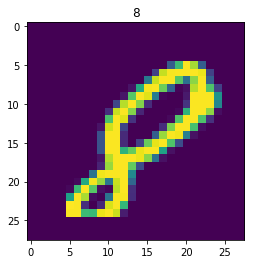

In [0]:
i = np.random.choice(range(50000))
img = torchvision.transforms.functional.to_pil_image(mnist_data[i][0])
label = mnist_data[i][1]

plt.figure()
plt.imshow(img)
plt.title(label)
plt.show()

In [0]:
BATCH_SIZE = 100

train_data, val_data = torch.utils.data.random_split(mnist_data, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True
                                          )

val_loader = torch.utils.data.DataLoader(val_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

test_mnist = torchvision.datasets.MNIST('./', download=True, train=False, transform=torchvision.transforms.ToTensor())
# test set 
test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=BATCH_SIZE, shuffle=True)
# 1-element batches for visualization
vis_loader = torch.utils.data.DataLoader(test_mnist, batch_size=1, shuffle=True)

In [0]:
def req_grad(model, state=True):
    """
    Detaches all parameters of the given model
    """
    for param in model.parameters():
        param.requires_grad_(state)

def plotter(x, x_adv, label, pred, pred_adv, method, noise=None):
    """
    Plots image, its adversarial perturbation, difference between then and added noise
    """ 
    
#     noise = x_adv - x
    img_noise = torchvision.transforms.functional.to_pil_image((x_adv - x).squeeze())
    x_adv = (x_adv - x_adv.min())/(x_adv.max() - x_adv.min())
    img_diff = torchvision.transforms.functional.to_pil_image((x_adv - x).squeeze())
    
    img = torchvision.transforms.functional.to_pil_image(x.squeeze())
    img_adv = torchvision.transforms.functional.to_pil_image(x_adv.squeeze())
    title_1 = "label: {} | pred: {}".format(label.item(), pred.item())
    title_2 = "label: {} | adversarial: {}".format(label.item(), pred_adv.item())
    
    plt.figure(figsize=(10,12))
    # original image
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title(title_1)
    # adversarial 
    plt.subplot(1, 4, 2)
    plt.imshow(img_adv, cmap='gray')
    plt.title(title_2)
    # image diff
    plt.subplot(1, 4, 3)
    plt.imshow(img_diff, cmap='gray')
    plt.title('image diference')
    # noise
    plt.subplot(1, 4, 4)
    plt.imshow(img_noise, cmap='gray')
    plt.title('rorshah test')
        
    plt.show()
    

In [0]:
def train(model, loader, loss, opt, train_hist, train_accuracy, verbose=True):
    model.train()
    N = 0
    for imgs, labels in loader:
        N += 1
        
        logits = model(imgs.cuda())
        predictions = (logits.data.max(1)[1]).detach().cpu()
        
        train_loss = loss(logits, labels.cuda())
        train_loss.backward()
        
        opt.step()
        opt.zero_grad()
        
        train_hist.append(train_loss.detach().cpu().item())
        train_accuracy.append(np.mean((predictions == labels).numpy()))
    
    if verbose:
        print('training   loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(train_hist[-1-N:-1]),
                                                                   np.mean(train_accuracy[-1-N:-1]) * 100))
        
    

def validation(model, loader, loss, opt, val_hist, val_accuracy, verbose=True):

    model.eval()
    
    N = 0
    for val_imgs, val_lab in loader:
        N += 1
        logits = model(val_imgs.cuda())
        preds = (logits.data.max(1)[1]).detach().cpu()
        
        val_loss = loss(logits, val_lab.cuda())
        val_hist.append(val_loss.cpu().item())
        
        val_acc_value = np.mean((preds == val_lab).numpy())
        val_accuracy.append(val_acc_value)
        
    if verbose:
        print('validation loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(val_hist[-1-N:-1]),
                                                            np.mean(val_accuracy[-1-N:-1]) * 100))  

In [0]:
def test_on_adv(model, loader, loss, params, method='fgsm', verbose=True, isplot=False, ismean=True, n_images=10):
    
    if isplot and loader.batch_size > 1:
        print('Can visualize only batches of size 1')
        isplot = False

            
            
    model.eval()
    loss_hist = []
    acc_hist = []
    
    loss_adv_hist = []
    acc_adv_hist = []
    
    req_grad(model, state=False) # detach all model's parameters

    N = 0
    for x, label in loader:

        N += 1
        x_adv = torch.clone(x)
        x_adv.requires_grad = True
        
        # prediction for original input 
        logits = model(x_adv.cuda())
        preds = (logits.data.max(1)[1]).detach().cpu()
        
        loss_val = loss(logits, label.cuda())
        loss_val.backward()
        
        x_adv.data = x_adv.data + params['eps'] * torch.sign(x_adv.grad.data)
        
        # perturbations
        if method == 'fgsm':
            steps = 0
            noise = params['eps'] * torch.sign(x_adv.grad.data)
            
        elif method == 'pgd':
            steps = params['steps'] - 1
            x_adv.data = torch.max(x-params['eps'], torch.min(x_adv.data, x+params['eps'])) # clipping to (x-eps; x+eps)
            
        logits_adv = model(x_adv.cuda())
        loss_adv = loss(logits_adv, label.cuda())
        loss_adv.backward()
        
        for k in range(steps):
            x_adv.data = x_adv.data + params['alpha'] * torch.sign(x_adv.grad.data)
            x_adv.data = torch.max(x-params['eps'], torch.min(x_adv.data, x+params['eps'])) # clipping to (x-eps; x+eps)

            logits_adv = model(x_adv.cuda())
            loss_adv = loss(logits_adv, label.cuda())
            loss_adv.backward()
            
        # predictions for adversarials 
        preds_adv = (logits_adv.data.max(1)[1]).detach().cpu()

        # accuracy
        acc_val = np.mean((preds == label).numpy())
        acc_adv = np.mean((preds_adv == label).numpy())

        loss_hist.append(loss_val.cpu().item())
        acc_hist.append(acc_val)
        
        loss_adv_hist.append(loss_adv.cpu().item())
        acc_adv_hist.append(acc_adv)
        
        if verbose:
            print('Batch', N)
            print('true      | loss: {:.2f} | accuracy: {:.2f}'.format(loss_val, acc_val * 100))
            print('perturbed | loss: {:.2f} | accuracy: {:.2f}%'.format(loss_adv, acc_adv * 100))
            
        if isplot:
            plotter(x, x_adv, label, preds, preds_adv, method)
            if N >= n_images: break
                
    
    if ismean:
        print('Loss: true x: {:.2f} | adversarial: {:.2f}'.format(np.mean(loss_hist), np.mean(loss_adv_hist)) )
        print('Accuracy: true x: {:.2f} | adversarial: {:.2f}'.format(np.mean(acc_hist) * 100, np.mean(acc_adv_hist) * 100))

            
    return (loss_hist, loss_adv_hist), (acc_hist, acc_adv_hist)

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)

    
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # define the architecture
        # MB DECREASE THE NUMBER OF PARAMETERS 
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        
        self.flat = Flatten()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()
        self.mpool = nn.MaxPool2d(2)
        self.softmax = nn.Softmax(dim=1)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.layers = nn.Sequential(
#             self.conv1,
#             self.relu,
#             self.mpool,
#             self.conv2,
#             self.relu,
#             self.mpool,
            
            self.flat,
            self.fc1,
            self.relu,
            self.fc2,
            self.relu,
            self.fc3
#             self.softmax
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

### Train the model for MNIST

In [0]:
model = Net().cuda()
adam_opt = torch.optim.Adam(model.parameters(), lr=1e-4)
ce_loss = nn.CrossEntropyLoss()

# TEST THE MODEL
# test_x = torch.randn((batch_size,1, 28, 28))
# test_out = model(test_x.cuda())
# del test_x, test_out

In [0]:
epochs = 25

train_hist = []
train_accuracy = []

val_hist = []
val_accuracy = []

for epoch in range(epochs):
    print('epoch', epoch+1)
    
        
    train(model, train_loader, ce_loss, adam_opt, train_hist, train_accuracy, verbose=True)
    
    validation(model, val_loader, ce_loss, adam_opt, val_hist, val_accuracy, verbose=True)
    
    
#     model.train()
#     N = 0
#     for imgs, labels in train_loader:
#         N += 1
        
# #         imgs.requires_grad_(True)
        
#         logits = model(imgs.cuda())
#         predictions = (logits.data.max(1)[1]).detach().cpu()
        
#         train_loss = loss(logits, labels.cuda())
#         train_loss.backward()
        
#         opt.step()
#         opt.zero_grad()
        
#         train_hist.append(train_loss.detach().cpu().item())
#         train_accuracy.append(np.mean((predictions == labels).numpy()))
    
#     print('training   loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(train_hist[-1-N:-1]),
#                                                             np.mean(train_accuracy[-1-N:-1]) * 100))
        
    # start validation part here
#     model.eval()
#     N = 0
#     for val_imgs, val_lab in val_loader:
#         N += 1
#         logits = model(val_imgs.cuda())
#         preds = (logits.data.max(1)[1]).detach().cpu()
        
#         val_loss = loss(logits, val_lab.cuda())
#         val_hist.append(val_loss.cpu().item())
        
#         val_acc_value = np.mean((preds == val_lab).numpy())
#         val_accuracy.append(val_acc_value)
        
#     print('validation loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(val_hist[-1-N:-1]),
#                                                             np.mean(val_accuracy[-1-N:-1]) * 100))

epoch 1
training   loss: 0.78 | accuracy: 82.81%
validation loss: 0.35 | accuracy: 90.29%
epoch 2
training   loss: 0.30 | accuracy: 91.68%
validation loss: 0.27 | accuracy: 92.33%
epoch 3
training   loss: 0.24 | accuracy: 93.32%
validation loss: 0.23 | accuracy: 93.48%
epoch 4
training   loss: 0.20 | accuracy: 94.30%
validation loss: 0.21 | accuracy: 93.91%
epoch 5
training   loss: 0.18 | accuracy: 94.96%
validation loss: 0.19 | accuracy: 94.44%
epoch 6
training   loss: 0.15 | accuracy: 95.55%
validation loss: 0.17 | accuracy: 94.92%
epoch 7
training   loss: 0.14 | accuracy: 96.08%
validation loss: 0.16 | accuracy: 95.23%
epoch 8
training   loss: 0.12 | accuracy: 96.48%
validation loss: 0.15 | accuracy: 95.50%
epoch 9
training   loss: 0.11 | accuracy: 96.80%
validation loss: 0.14 | accuracy: 95.59%
epoch 10
training   loss: 0.10 | accuracy: 97.10%
validation loss: 0.13 | accuracy: 95.97%
epoch 11
training   loss: 0.09 | accuracy: 97.44%
validation loss: 0.12 | accuracy: 96.10%
epoch 12

In [0]:
torch.save(model, 'model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Test the model on adversarial examples

In [0]:
# parameters for adversarials

fgsm_params = {'eps': 0.05}
pgd_params = {'eps' : 0.15, 'steps' : 10, 'alpha' : 1}

In [149]:
# accuracy on adversarial batches from test set
fgsm_params = {'eps': 0.05}
pgd_params = {'eps' : 0.15, 'steps' : 10, 'alpha' : 1}
loss_hist, accuracy_hist = test_on_adv(model, test_loader, ce_loss, fgsm_params, method='fgsm', ismean=True, verbose=False)

# loss_his, accuracy = test_on_adv(model, vis_loader, ce_loss, pdg_params, method='pdg', verbose=True)

Loss: true x: 0.07 | adversarial: 7.71
Accuracy: true x: 97.81 | adversarial: 10.56


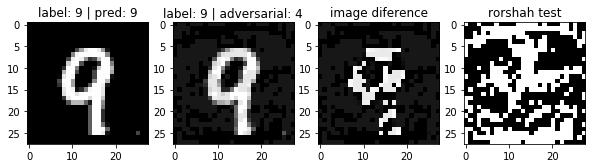

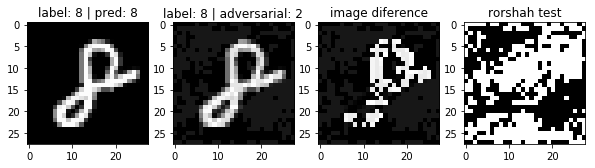

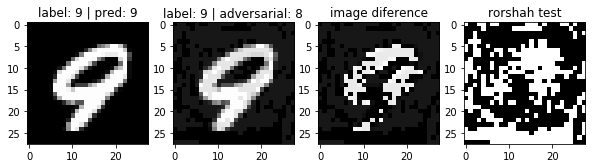

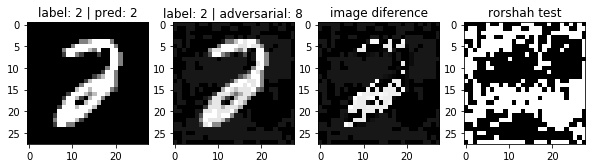

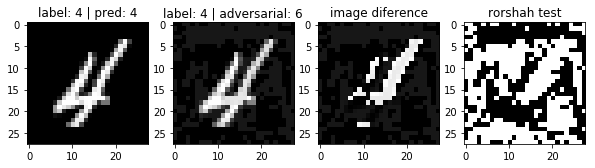

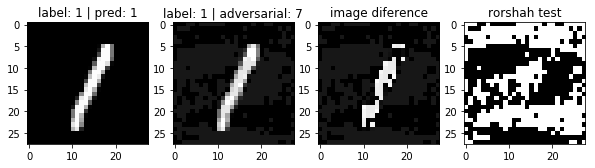

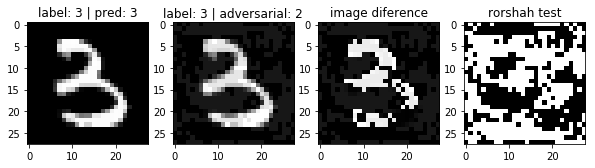

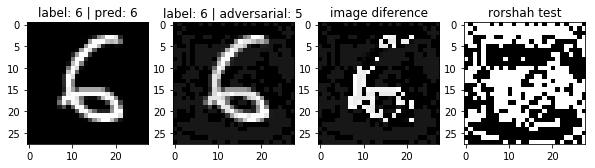

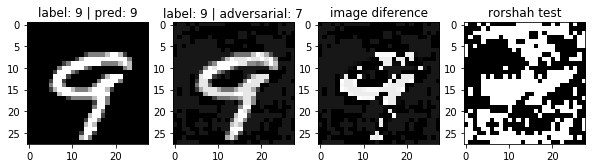

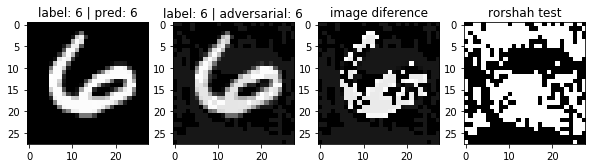

Loss: true x: 0.02 | adversarial: 8.35
Accuracy: true x: 100.00 | adversarial: 10.00


In [0]:
# visualization on data from test set

history, accuracy = test_on_adv(model, vis_loader, ce_loss, fgsm_params, method='fgsm', verbose=False, isplot=True, n_images=10)
# history, accuracy = test_on_adv(model, vis_loader, ce_loss, pgd_params, method='pgd', verbose=False, isplot=True)

### IBP

In [0]:
def compute_bounds(model, x, eps=0.1):
    """
    Computes lower and upper bounds for z_k as equation (6) in 
    
        https://arxiv.org/abs/1810.12715
        
    """
    bounds = []
    
    # if we have convolutional layers we need to reshape input to flat vectors before FC layers 
    
#     bounds.append((x.view(x.shape[0], -1) - eps, x.view(x.shape[0], -1) + eps)) # reshaping to flat vectors
    bounds.append((x - eps, x + eps))
#     z0_low = x - model.eps
#     z0_up = x + model.eps
    
#     k = 1
    for layer in model.layers:
        
        z_l_prev, z_u_prev = bounds[-1]
        
        if isinstance(layer, Flatten):
            z_l = Flatten()(z_l_prev)
            z_u = Flatten()(z_u_prev)
            
            bounds.append((z_l, z_u))
        
        if isinstance(layer, nn.Linear):
#             print(z_l_prev.shape)
#             print(layer.weight.shape)
            W = layer.weight
            b = layer.bias

            m = (z_u_prev + z_l_prev) / 2
            r = (z_u_prev - z_l_prev) / 2

            m = torch.matmul(m, W.t()) + b
            r = torch.matmul(r, torch.abs(W.t()))

            z_l = m - r
            z_u = m + r
            bounds.append((z_l, z_u))
#             k += 1
            
        elif isinstance(layer, nn.Conv2d):
            
#             continue 
#             print(z_l_prev.shape)
#             print(layer.weight.shape)
            z_l = (F.conv2d(z_l_prev, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  F.conv2d(z_u_prev, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            z_u = (F.conv2d(z_u_prev, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  F.conv2d(z_l_prev, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            bounds.append((z_l, z_u))
#             m = (z_u_prev + z_l_prev) / 2
#             r = (z_u_prev - z_l_prev) / 2
#             stride = layer.stride
#             padding = layer.padding
#             out_m = F.conv2d(m, layer.weight, None, stride,
#                         padding)#, self.dilation, self.groups)
#             out_r = F.conv2d(r, torch.abs(layer.weight), None, stride,
#                         padding)#, self.dilation, self.groups)
            
#             # this part should be rewritten with F.conv...
# #             m = torch.matmul(m, W.t()) + b
# #             r = torch.matmul(r, torch.abs(W.t()))

#             z_l = out_m - out_r
#             z_u = out_m + out_r
#             bounds.append((z_l, z_u))

        elif isinstance(layer, nn.ReLU):
            
            z_l = torch.relu(z_l_prev)
            z_u = torch.relu(z_u_prev)
            
            bounds.append((z_l, z_u))
        
        else: 
            continue
        
    return bounds

In [0]:
def ibp_loss(base_loss, logits, z_k, y, k=0.5):

    e_y = torch.zeros((1, logits.shape[1])).to('cuda')
    e_y[:, y] = 1
    z_hat =  e_y * z_k[0] + (1 - e_y) * z_k[1]
    
    L_spec = base_loss(z_hat, y)
    L_fit = base_loss(logits, y)
    
    L = k * L_fit + (1 - k) * L_spec
    
    return L, L_spec, L_fit

In [0]:
# x, y = next(iter(vis_loader))
# base_loss = nn.CrossEntropyLoss()
# #     model.cpu()
# req_grad(model, state=True)

In [0]:
# with torch.autograd.set_detect_anomaly(True):

#     bounds = compute_bounds(model, x.cuda())
#     z_k = bounds[-1]
#     logits = model(x.cuda())
    
#     # creating z_hat 
#     e_y = torch.zeros((1, logits.shape[1])).to('cuda')
#     e_y[:, y] = 1

    
#     z_hat = e_y * z_k[0] + (1 - e_y) * z_k[1]

#     L_spec = base_loss(z_hat.cuda(), y.cuda())


#     L = ibp_loss(base_loss, logits, z_k, y.cuda())
    
#     L_spec.backward()
#     L.backward()

### Test IBP training

In [0]:
verbose = True
epochs = 10
base_loss = nn.CrossEntropyLoss()
# req_grad(model, state=True)

ibp_train_hist = []
ibp_train_accuracy = []

val_hist_ibp = []
val_accuracy_ibp = []

ibp_model = Net().cuda()
ibp_opt = torch.optim.Adam(ibp_model.parameters(), lr=1e-3)

In [0]:
L_spec_hist = []
L_fit_hist = []

ibp_model.train()
for epoch in range(epochs):
    
    print('epoch:', epoch+1)
    N = 0
    for imgs, labels in train_loader:
        N += 1

        logits = ibp_model(imgs.cuda())
        predictions = (logits.data.max(1)[1]).detach().cpu()
        bounds = compute_bounds(ibp_model, imgs.cuda())
        z_k = bounds[-1]


        train_loss, L_spec, L_fit = ibp_loss(base_loss, logits, z_k, labels.cuda())
        train_loss.backward()

        ibp_opt.step()
        ibp_opt.zero_grad()

        ibp_train_hist.append(train_loss.detach().cpu().item())
        ibp_train_accuracy.append(np.mean((predictions == labels).numpy()))
        
        L_spec_hist.append(L_spec.detach().cpu().item())
        L_fit_hist.append(L_fit.detach().cpu().item())
        
    validation(ibp_model, val_loader, ce_loss, ibp_opt, val_hist_ibp, val_accuracy_ibp, verbose=True)
    
    if verbose:
        print('training   loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(ibp_train_hist[-1-N:-1]),
                                                                       np.mean(ibp_train_accuracy[-1-N:-1]) * 100))
        
        print('L_spec: {:.2f} | L_fit: {:.2f}'.format(np.mean(L_spec_hist[-1-N:-1]), np.mean(L_fit_hist[-1-N:-1])) )

epoch: 1
validation loss: 0.20 | accuracy: 94.12%
training   loss: 0.56 | accuracy: 88.27%
L_spec: 0.70 | L_fit: 0.42
epoch: 2
validation loss: 0.14 | accuracy: 96.06%
training   loss: 0.18 | accuracy: 95.75%
L_spec: 0.22 | L_fit: 0.15
epoch: 3
validation loss: 0.11 | accuracy: 96.79%
training   loss: 0.13 | accuracy: 97.01%
L_spec: 0.16 | L_fit: 0.10
epoch: 4
validation loss: 0.09 | accuracy: 97.24%
training   loss: 0.10 | accuracy: 97.80%
L_spec: 0.13 | L_fit: 0.07
epoch: 5
validation loss: 0.09 | accuracy: 97.36%
training   loss: 0.08 | accuracy: 98.28%
L_spec: 0.11 | L_fit: 0.06
epoch: 6
validation loss: 0.08 | accuracy: 97.64%
training   loss: 0.07 | accuracy: 98.63%
L_spec: 0.09 | L_fit: 0.05
epoch: 7
validation loss: 0.08 | accuracy: 97.65%
training   loss: 0.05 | accuracy: 98.95%
L_spec: 0.07 | L_fit: 0.04
epoch: 8
validation loss: 0.07 | accuracy: 97.72%
training   loss: 0.05 | accuracy: 99.13%
L_spec: 0.07 | L_fit: 0.03
epoch: 9
validation loss: 0.07 | accuracy: 97.90%
traini

In [0]:
def ibp_train(model, loader, loss, compute_bounds,  verbose=True):
    
    N = 0
    for imgs, labels in loader:
        N += 1

        logits = model(imgs.cuda())
        predictions = (logits.data.max(1)[1]).detach().cpu()
        bounds = compute_bounds(model, imgs.cuda())
        z_k = bounds[-1]
        
        
        train_loss = loss(logits, labels.cuda())
        train_loss.backward()

        opt.step()
        opt.zero_grad()

        train_hist.append(train_loss.detach().cpu().item())
        train_accuracy.append(np.mean((predictions == labels).numpy()))

    if verbose:
        print('training   loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(train_hist[-1-N:-1]),
                                                                       np.mean(train_accuracy[-1-N:-1]) * 100))
        
        
        



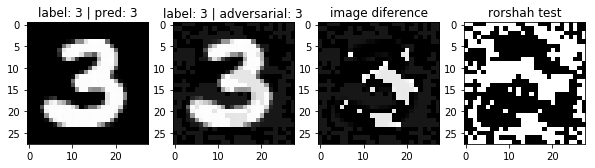

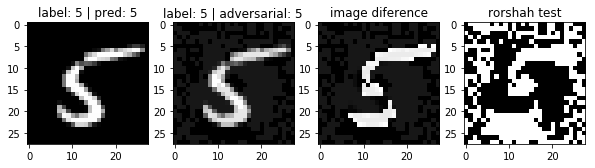

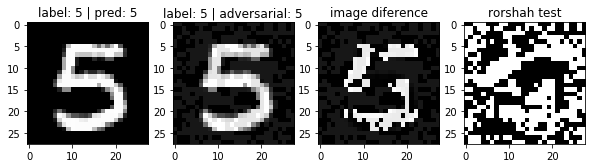

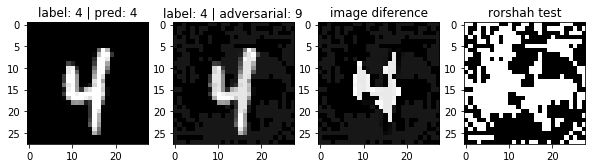

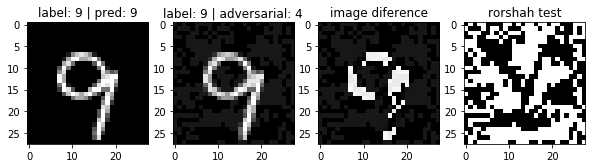

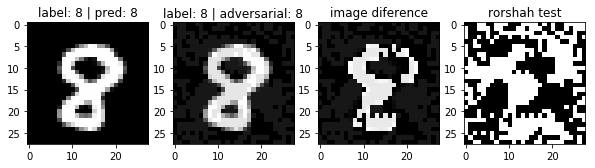

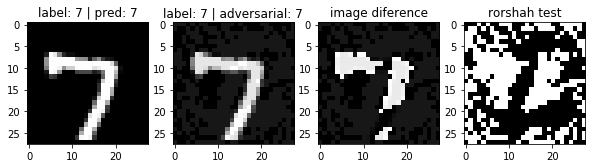

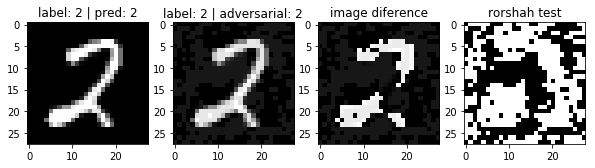

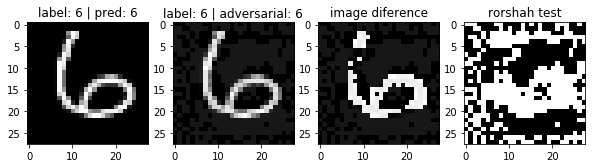

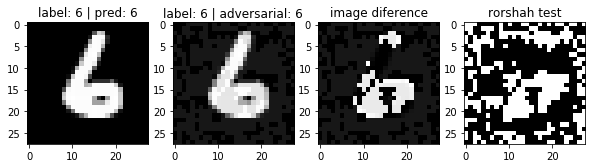

Loss: true x: 0.00 | adversarial: 0.28
Accuracy: true x: 100.00 | adversarial: 80.00


In [0]:
ce_loss = nn.CrossEntropyLoss()

fgsm_params = {'eps': 0.05}
# loss_his, accuracy = test_on_adv(ibp_model, test_loader, ce_loss, fgsm_params, method='fgsm', verbose=True)
loss_his, accuracy = test_on_adv(ibp_model, vis_loader, ce_loss, fgsm_params, method='fgsm', verbose=False, isplot=True)

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
#         return x.view(-1, x.shape[0])
        return x.view(x.shape[0], -1)

    
class Net2(nn.Module):
    
    def __init__(self):
        super(Net2, self).__init__()
        
        # define the architecture
        # MB DECREASE THE NUMBER OF PARAMETERS 
        
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(20, 64, kernel_size=3)
        
        self.flat = Flatten()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.fc4 = nn.Linear(43264, 10)
        
        self.relu = nn.ReLU()
        self.mpool = nn.MaxPool2d(2)
        self.softmax = nn.Softmax(dim=1)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.layers = nn.Sequential(
#             self.flat,
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.flat,
            self.fc4
            
#             self.flat,
#             self.conv1,
#             self.relu,
#             self.conv2,
#             self.relu,
#             self.mpool
#             self.softmax
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [0]:
model = Net2().cuda()
adam_opt = torch.optim.Adam(model.parameters(), lr=1e-4)
ce_loss = nn.CrossEntropyLoss()

In [154]:
epochs = 20

train_hist = []
train_accuracy = []

val_hist = []
val_accuracy = []

for epoch in range(epochs):
    print('epoch', epoch+1)
    
        
    train(model, train_loader, ce_loss, adam_opt, train_hist, train_accuracy, verbose=True)
    
    validation(model, val_loader, ce_loss, adam_opt, val_hist, val_accuracy, verbose=True)
    
    

epoch 1
training   loss: 0.49 | accuracy: 86.93%
validation loss: 0.27 | accuracy: 92.10%
epoch 2
training   loss: 0.22 | accuracy: 93.88%
validation loss: 0.18 | accuracy: 94.79%
epoch 3
training   loss: 0.13 | accuracy: 96.26%
validation loss: 0.12 | accuracy: 96.64%
epoch 4
training   loss: 0.09 | accuracy: 97.51%
validation loss: 0.10 | accuracy: 97.32%
epoch 5
training   loss: 0.07 | accuracy: 97.95%
validation loss: 0.09 | accuracy: 97.40%
epoch 6
training   loss: 0.06 | accuracy: 98.33%
validation loss: 0.07 | accuracy: 97.70%
epoch 7
training   loss: 0.05 | accuracy: 98.46%
validation loss: 0.07 | accuracy: 97.87%
epoch 8
training   loss: 0.05 | accuracy: 98.67%
validation loss: 0.07 | accuracy: 97.86%
epoch 9
training   loss: 0.04 | accuracy: 98.79%
validation loss: 0.07 | accuracy: 97.97%
epoch 10
training   loss: 0.04 | accuracy: 98.90%
validation loss: 0.06 | accuracy: 98.13%
epoch 11
training   loss: 0.03 | accuracy: 98.96%
validation loss: 0.06 | accuracy: 97.98%
epoch 12

In [155]:
fgsm_params = {'eps': 0.1}
pgd_params = {'eps' : 0.15, 'steps' : 10, 'alpha' : 1}
loss_hist, accuracy_hist = test_on_adv(model, test_loader, ce_loss, fgsm_params, method='fgsm', ismean=True, verbose=False)

Loss: true x: 0.06 | adversarial: 6.81
Accuracy: true x: 98.49 | adversarial: 21.73


In [162]:
torch.save(model, "model_conv.pth")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
verbose = True
epochs = 10
base_loss = nn.CrossEntropyLoss()
# req_grad(model, state=True)

ibp_train_hist = []
ibp_train_accuracy = []

val_hist_ibp = []
val_accuracy_ibp = []

ibp_model_0 = Net2().cuda()
ibp_opt_0 = torch.optim.Adam(ibp_model_0.parameters(), lr=1e-3)

In [183]:
L_spec_hist = []
L_fit_hist = []

ibp_model_0.train()
for epoch in range(epochs):
    
    print('epoch:', epoch+1)
    N = 0
    for imgs, labels in train_loader:
        N += 1

        logits = ibp_model_0(imgs.cuda())
        predictions = (logits.data.max(1)[1]).detach().cpu()
        bounds = compute_bounds(ibp_model_0, imgs.cuda())
        z_k = bounds[-1]


        train_loss, L_spec, L_fit = ibp_loss(base_loss, logits, z_k, labels.cuda())
        train_loss.backward()

        ibp_opt_0.step()
        ibp_opt_0.zero_grad()

        ibp_train_hist.append(train_loss.detach().cpu().item())
        ibp_train_accuracy.append(np.mean((predictions == labels).numpy()))
        
        L_spec_hist.append(L_spec.detach().cpu().item())
        L_fit_hist.append(L_fit.detach().cpu().item())
        
    validation(ibp_model_0, val_loader, ce_loss, ibp_opt_0, val_hist_ibp, val_accuracy_ibp, verbose=True)
    
    if verbose:
        print('training   loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(ibp_train_hist[-1-N:-1]),
                                                                       np.mean(ibp_train_accuracy[-1-N:-1]) * 100))
        
        print('L_spec: {:.2f} | L_fit: {:.2f}'.format(np.mean(L_spec_hist[-1-N:-1]), np.mean(L_fit_hist[-1-N:-1])) )

epoch: 1
validation loss: 0.12 | accuracy: 96.61%
training   loss: 0.44 | accuracy: 89.45%
L_spec: 0.49 | L_fit: 0.39
epoch: 2
validation loss: 0.08 | accuracy: 97.67%
training   loss: 0.09 | accuracy: 97.54%
L_spec: 0.10 | L_fit: 0.08
epoch: 3
validation loss: 0.07 | accuracy: 97.84%
training   loss: 0.06 | accuracy: 98.20%
L_spec: 0.07 | L_fit: 0.06
epoch: 4
validation loss: 0.07 | accuracy: 97.98%
training   loss: 0.05 | accuracy: 98.65%
L_spec: 0.05 | L_fit: 0.04
epoch: 5
validation loss: 0.06 | accuracy: 98.23%
training   loss: 0.04 | accuracy: 98.88%
L_spec: 0.04 | L_fit: 0.03
epoch: 6
validation loss: 0.07 | accuracy: 98.06%
training   loss: 0.03 | accuracy: 99.25%
L_spec: 0.03 | L_fit: 0.03
epoch: 7
validation loss: 0.07 | accuracy: 98.14%
training   loss: 0.02 | accuracy: 99.36%
L_spec: 0.02 | L_fit: 0.02
epoch: 8
validation loss: 0.08 | accuracy: 97.97%
training   loss: 0.02 | accuracy: 99.49%
L_spec: 0.02 | L_fit: 0.02
epoch: 9
validation loss: 0.08 | accuracy: 98.12%
traini

In [0]:
fgsm_params = {'eps': 0.1}
pgd_params = {'eps' : 0.15, 'steps' : 10, 'alpha' : 1}
loss_hist_1, accuracy_hist_1 = test_on_adv(ibp_model, test_loader, ce_loss, fgsm_params, method='fgsm', ismean=True, verbose=False)

Loss: true x: 0.06 | adversarial: 1.20
Accuracy: true x: 98.28 | adversarial: 68.67


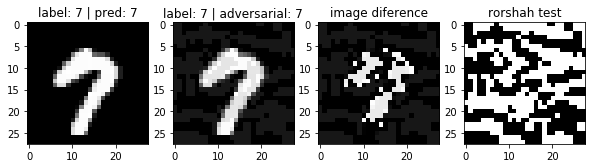

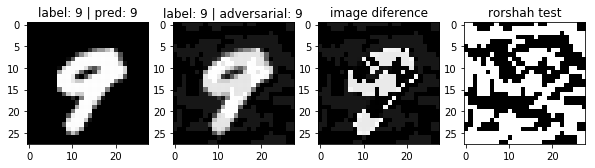

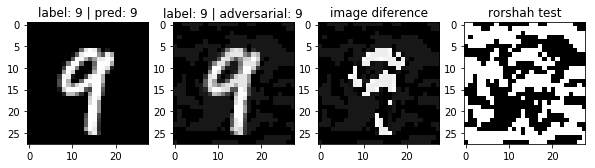

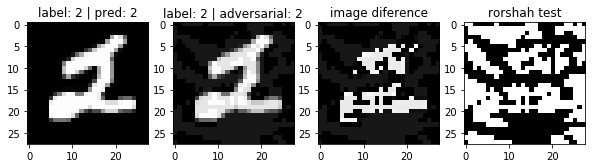

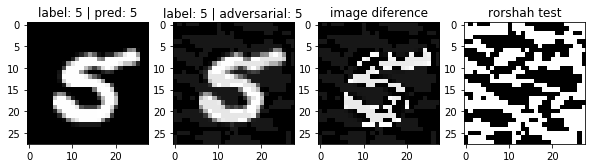

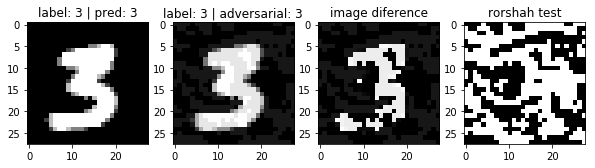

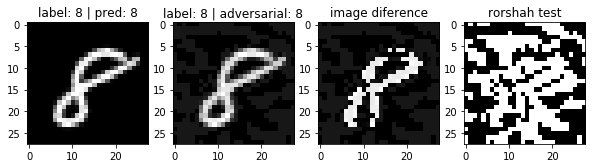

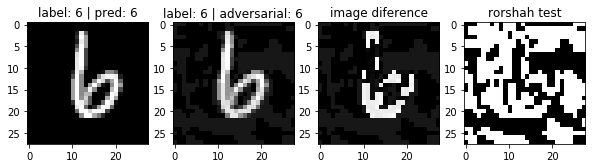

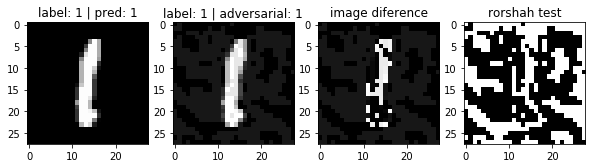

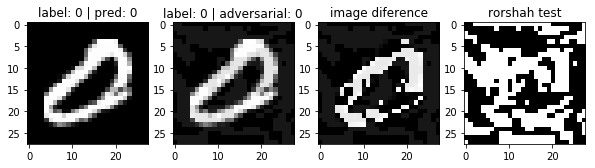

Loss: true x: 0.00 | adversarial: 0.10
Accuracy: true x: 100.00 | adversarial: 100.00


In [0]:
ce_loss = nn.CrossEntropyLoss()

fgsm_params = {'eps': 0.05}
# loss_his, accuracy = test_on_adv(ibp_model, test_loader, ce_loss, fgsm_params, method='fgsm', verbose=True)
loss_his, accuracy = test_on_adv(model, vis_loader, ce_loss, fgsm_params, method='fgsm', verbose=False, isplot=True)

## CR

In [0]:
def curvature_regularization_loss(model, lossf, x, h, y=None, attack_norm_p='inf'):
    """
    Computes curvature regularization term.
    
    The formula is L(x) = \| \nabla l(x + h z) - \nabla l(x) \|^2,
    where z depends on attack norm. If attack is in \ell_inf, then
    z = sign \nabla l(x) / \| sign \nabla l(x) \|. Another good
    choice is z = \nabla l(x) / \| \nabla l(x) \|.
    
    Args:
        model, lossf (Module): model and corresponding loss function
        x, y (Tensor): data and optional label
        h (float): interpolation parameter
        attack_norm_p (str): if 'inf', \ell_inf z is used, otherwise
            simply normalized gradient.
    """
    original = x.clone().detach().requires_grad_(True)
    prob_original = lossf(model(original), y) if y is not None else lossf(model(original))
    gradients_original = torch.autograd.grad(outputs=prob_original,
                                             inputs=original,
                                             grad_outputs=torch.ones(prob_original.size()).cuda(),
                                             create_graph=True,
                                             retain_graph=True)[0]
    
    # do not back-propagate through z
    if attack_norm_p == 'inf':
        z = gradients_original.clone().detach().sign()
    else:
        z = gradients_original.clone().detach()
    
    interpolated = (x + h * z).requires_grad_(True)
    prob_interpolated = lossf(model(interpolated), y) if y is not None else lossf(model(interpolated))
    gradients_interpolated = torch.autograd.grad(outputs=prob_interpolated,
                                                 inputs=interpolated,
                                                 grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                                                 create_graph=True,
                                                 retain_graph=True)[0]

    return torch.sum((gradients_interpolated - gradients_original) ** 2)

In [0]:
def update_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [0]:
model2 = Net2()
model2.cuda()
opt = torch.optim.Adam(model2.parameters())
loss = nn.CrossEntropyLoss()

In [0]:
epochs = 20
epochs_burnin = 5
lr_schedule = np.flip(np.linspace(1e-6, 1e-4, epochs))
h_schedule = np.linspace(0, 1.5, epochs_burnin).tolist() + np.repeat([1.5], epochs-epochs_burnin).tolist()
cr_weight = 4

In [0]:
def train_model(model, optimizer, lossf, dataloader, lr_schedule, h_schedule, cr_weight, epochs=epochs):
    for epoch, lr, h in zip(range(epochs), lr_schedule, h_schedule):
        update_rate(optimizer, lr)
        losses = []
        for idx, (batch, labels) in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            loss = lossf(model(batch.cuda()), labels.cuda())
            full_loss = loss + cr_weight * curvature_regularization_loss(model, lossf, batch.cuda(), h, labels.cuda())
            losses.append(full_loss.detach().cpu().numpy())
            full_loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print('[%2d]\tloss\t%.7f' % (epoch+1, np.mean(losses)))

In [0]:
verbose = True
epochs = 10
base_loss = nn.CrossEntropyLoss()
# req_grad(model, state=True)

ibp_train_hist = []
ibp_train_accuracy = []

val_hist_ibp = []
val_accuracy_ibp = []

ibp_model = Net2().cuda()
ibp_opt = torch.optim.Adam(ibp_model.parameters(), lr=1e-3)

In [176]:
L_spec_hist = []
L_fit_hist = []

ibp_model.train()
for epoch, h in zip(range(epochs), h_schedule):
    
    print('epoch:', epoch+1)
    N = 0
    for imgs, labels in train_loader:
        N += 1

        logits = ibp_model(imgs.cuda())
        predictions = (logits.data.max(1)[1]).detach().cpu()
        bounds = compute_bounds(ibp_model, imgs.cuda())
        z_k = bounds[-1]


        train_loss, L_spec, L_fit = ibp_loss(base_loss, logits, z_k, labels.cuda())
        cr_l = cr_weight * curvature_regularization_loss(ibp_model, base_loss, imgs.cuda(), h, labels.cuda())
        loss = train_loss + cr_l
        loss.backward()

        ibp_opt.step()
        ibp_opt.zero_grad()

        ibp_train_hist.append(loss.detach().cpu().item())
        ibp_train_accuracy.append(np.mean((predictions == labels).numpy()))
        
        L_spec_hist.append(L_spec.detach().cpu().item())
        L_fit_hist.append(L_fit.detach().cpu().item())
        
    validation(ibp_model, val_loader, ce_loss, ibp_opt, val_hist_ibp, val_accuracy_ibp, verbose=True)
    
    if verbose:
        print('training   loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(ibp_train_hist[-1-N:-1]),
                                                                       np.mean(ibp_train_accuracy[-1-N:-1]) * 100))
        
        print('L_spec: {:.2f} | L_fit: {:.2f}'.format(np.mean(L_spec_hist[-1-N:-1]), np.mean(L_fit_hist[-1-N:-1])) )

epoch: 1
validation loss: 0.14 | accuracy: 95.85%
training   loss: 0.47 | accuracy: 88.45%
L_spec: 0.53 | L_fit: 0.42
epoch: 2
validation loss: 0.17 | accuracy: 96.25%
training   loss: 0.36 | accuracy: 95.87%
L_spec: 0.33 | L_fit: 0.21
epoch: 3
validation loss: 0.09 | accuracy: 97.55%
training   loss: 0.14 | accuracy: 97.22%
L_spec: 0.10 | L_fit: 0.11
epoch: 4
validation loss: 0.07 | accuracy: 98.14%
training   loss: 0.08 | accuracy: 98.14%
L_spec: 0.07 | L_fit: 0.07
epoch: 5
validation loss: 0.07 | accuracy: 98.17%
training   loss: 0.06 | accuracy: 98.56%
L_spec: 0.05 | L_fit: 0.05
epoch: 6
validation loss: 0.06 | accuracy: 98.32%
training   loss: 0.05 | accuracy: 98.77%
L_spec: 0.05 | L_fit: 0.04
epoch: 7
validation loss: 0.06 | accuracy: 98.19%
training   loss: 0.05 | accuracy: 99.04%
L_spec: 0.04 | L_fit: 0.03
epoch: 8


KeyboardInterrupt: ignored

In [178]:
torch.save(ibp_model, "ibp+cr.pth")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [177]:
fgsm_params = {'eps': 0.1}
pgd_params = {'eps' : 0.15, 'steps' : 10, 'alpha' : 1}
loss_hist_2, accuracy_hist_2 = test_on_adv(ibp_model, test_loader, ce_loss, fgsm_params, method='fgsm', ismean=True, verbose=False)

Loss: true x: 0.05 | adversarial: 0.53
Accuracy: true x: 98.42 | adversarial: 83.11


In [180]:
pgd_params = {'eps' : 0.1, 'steps' : 10, 'alpha' : 1}
loss_hist, accuracy_hist = test_on_adv(ibp_model, test_loader, ce_loss, pgd_params, method='pgd', ismean=True, verbose=False)

Loss: true x: 0.05 | adversarial: 0.66
Accuracy: true x: 98.42 | adversarial: 78.26


In [185]:
pgd_params = {'eps' : 0.15, 'steps' : 20, 'alpha' : 1}
loss_hist, accuracy_hist = test_on_adv(ibp_model, test_loader, ce_loss, pgd_params, method='pgd', ismean=True, verbose=False)

Loss: true x: 0.05 | adversarial: 2.11
Accuracy: true x: 98.42 | adversarial: 37.09


In [181]:
pgd_params = {'eps' : 0.1, 'steps' : 10, 'alpha' : 1}
loss_hist, accuracy_hist = test_on_adv(model, test_loader, ce_loss, pgd_params, method='pgd', ismean=True, verbose=False)

Loss: true x: 0.06 | adversarial: 9.11
Accuracy: true x: 98.49 | adversarial: 2.46


In [184]:
ibp_model_0
pgd_params = {'eps' : 0.1, 'steps' : 10, 'alpha' : 1}
loss_hist, accuracy_hist = test_on_adv(ibp_model_0, test_loader, ce_loss, pgd_params, method='pgd', ismean=True, verbose=False)

Loss: true x: 0.07 | adversarial: 2.89
Accuracy: true x: 98.31 | adversarial: 49.54


In [186]:
pgd_params = {'eps' : 0.15, 'steps' : 20, 'alpha' : 1}
loss_hist, accuracy_hist = test_on_adv(ibp_model_0, test_loader, ce_loss, pgd_params, method='pgd', ismean=True, verbose=False)

Loss: true x: 0.07 | adversarial: 9.78
Accuracy: true x: 98.31 | adversarial: 6.71


In [188]:
pgd_params = {'eps' : 0.15, 'steps' : 20, 'alpha' : 1}
loss_hist, accuracy_hist = test_on_adv(model, test_loader, ce_loss, pgd_params, method='pgd', ismean=True, verbose=False)

Loss: true x: 0.06 | adversarial: 20.21
Accuracy: true x: 98.49 | adversarial: 0.00


In [191]:
torch.save(model, "model0.pth")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Appendix